In [1]:
print("Installing required packages...")

# Let captum set the numpy version
!pip install -q captum
!pip install -q kagglehub lime scikit-image

print(" Packages installed!")
print(" MANUALLY RESTART: Go to Runtime > Restart runtime")

Installing required packages...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 90.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

# XAI Libraries
from captum.attr import LayerGradCam
from lime import lime_image
from skimage.segmentation import mark_boundaries

print("✓ All libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ All libraries imported successfully
PyTorch version: 2.9.0+cu126
CUDA available: True


In [3]:
import kagglehub

# Download latest version
print("Downloading dataset from Kaggle...")
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path)

DATASET_BASE_PATH = os.path.join(path, "chest_xray")
print(f"\nDataset base path: {DATASET_BASE_PATH}")

# Verify dataset structure
for split in ['train', 'test']:
    split_path = os.path.join(DATASET_BASE_PATH, split)
    if os.path.exists(split_path):
        print(f"✓ Found {split} directory")
        for class_name in ['NORMAL', 'PNEUMONIA']:
            class_path = os.path.join(split_path, class_name)
            if os.path.exists(class_path):
                num_images = len([f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
                print(f"  - {class_name}: {num_images} images")


Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia

Dataset base path: /kaggle/input/chest-xray-pneumonia/chest_xray
✓ Found train directory
  - NORMAL: 1341 images
  - PNEUMONIA: 3875 images
✓ Found test directory
  - NORMAL: 234 images
  - PNEUMONIA: 390 images


In [4]:
class Config:
    """Configuration parameters for the entire pipeline"""

    # Paths
    TRAIN_DIR = os.path.join(DATASET_BASE_PATH, 'train')
    TEST_DIR = os.path.join(DATASET_BASE_PATH, 'test')

    # Model parameters
    MODEL_NAME = 'densenet121'
    NUM_CLASSES = 2
    PRETRAINED = True

    # Training parameters
    BATCH_SIZE = 32
    NUM_EPOCHS = 15  # Increased epochs
    LEARNING_RATE = 0.0001  # Reduced learning rate
    WEIGHT_DECAY = 1e-4  # L2 regularization
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Validation split
    VAL_SPLIT = 0.2  # Use 20% of training data for validation

    # Image parameters
    IMG_SIZE = 224
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]

    # Enhanced data augmentation
    ROTATION_DEGREES = 15
    BRIGHTNESS = 0.2
    CONTRAST = 0.2

    # Class weights for imbalanced dataset
    USE_CLASS_WEIGHTS = True

    # Output
    MODEL_SAVE_PATH = 'densenet121_pneumonia_detector.pth'
    RESULTS_DIR = 'results'

print(f"✓ Configuration set")
print(f"  Device: {Config.DEVICE}")
print(f"  Batch size: {Config.BATCH_SIZE}")
print(f"  Epochs: {Config.NUM_EPOCHS}")
print(f"  Learning rate: {Config.LEARNING_RATE}")
print(f"  Validation split: {Config.VAL_SPLIT}")

✓ Configuration set
  Device: cuda
  Batch size: 32
  Epochs: 15
  Learning rate: 0.0001
  Validation split: 0.2


In [5]:
class ChestXRayDataset(Dataset):
    """Custom Dataset for Chest X-Ray images"""

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['NORMAL', 'PNEUMONIA']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.exists(class_dir):
                continue

            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_dir, img_name)
                    self.samples.append((img_path, self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

print("✓ Dataset class defined")


✓ Dataset class defined


In [6]:
def get_data_transforms():
    """Define enhanced data transformations"""
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
            transforms.RandomRotation(Config.ROTATION_DEGREES),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ColorJitter(
                brightness=Config.BRIGHTNESS,
                contrast=Config.CONTRAST
            ),
            transforms.ToTensor(),
            transforms.Normalize(Config.MEAN, Config.STD)
        ]),
        'val': transforms.Compose([
            transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(Config.MEAN, Config.STD)
        ])
    }
    return data_transforms


def create_dataloaders():
    """Create DataLoaders with proper train/val split"""
    transforms_dict = get_data_transforms()

    # Load full training dataset
    full_train_dataset = ChestXRayDataset(Config.TRAIN_DIR, transform=None)

    # Get labels for stratified split
    labels = [label for _, label in full_train_dataset.samples]

    # Stratified split for train/val
    train_indices, val_indices = train_test_split(
        range(len(full_train_dataset)),
        test_size=Config.VAL_SPLIT,
        stratify=labels,
        random_state=42
    )

    # Create separate datasets with appropriate transforms
    train_samples = [full_train_dataset.samples[i] for i in train_indices]
    val_samples = [full_train_dataset.samples[i] for i in val_indices]

    train_dataset = ChestXRayDataset(Config.TRAIN_DIR, transform=transforms_dict['train'])
    train_dataset.samples = train_samples

    val_dataset = ChestXRayDataset(Config.TRAIN_DIR, transform=transforms_dict['val'])
    val_dataset.samples = val_samples

    test_dataset = ChestXRayDataset(Config.TEST_DIR, transform=transforms_dict['val'])

    # Calculate class weights for imbalanced dataset
    train_labels = [label for _, label in train_samples]
    class_counts = np.bincount(train_labels)
    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.sum()

    print(f"\nDataset Distribution:")
    print(f"  Train: {len(train_dataset)} images")
    print(f"    - NORMAL: {train_labels.count(0)} ({train_labels.count(0)/len(train_labels)*100:.1f}%)")
    print(f"    - PNEUMONIA: {train_labels.count(1)} ({train_labels.count(1)/len(train_labels)*100:.1f}%)")
    print(f"  Validation: {len(val_dataset)} images")
    val_labels = [label for _, label in val_samples]
    print(f"    - NORMAL: {val_labels.count(0)} ({val_labels.count(0)/len(val_labels)*100:.1f}%)")
    print(f"    - PNEUMONIA: {val_labels.count(1)} ({val_labels.count(1)/len(val_labels)*100:.1f}%)")
    print(f"  Test: {len(test_dataset)} images")

    print(f"\nClass Weights: NORMAL={class_weights[0]:.4f}, PNEUMONIA={class_weights[1]:.4f}")

    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE,
                            shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE,
                          shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE,
                           shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader, torch.FloatTensor(class_weights)

print("✓ Enhanced data preparation functions defined")

✓ Enhanced data preparation functions defined


In [7]:
class PneumoniaDetector(nn.Module):
    """Improved DenseNet121-based classifier"""

    def __init__(self, num_classes=2, pretrained=True):
        super(PneumoniaDetector, self).__init__()

        # Load DenseNet121 with updated weights parameter
        if pretrained:
            self.densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        else:
            self.densenet = models.densenet121(weights=None)

        num_features = self.densenet.classifier.in_features

        # Enhanced classifier with batch normalization
        self.densenet.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.densenet(x)

print("✓ Improved model architecture defined")

✓ Improved model architecture defined


In [8]:
def train_model(model, train_loader, val_loader, num_epochs, class_weights):
    """Enhanced training with class weights and early stopping"""

    # Weighted loss for imbalanced dataset
    if Config.USE_CLASS_WEIGHTS:
        criterion = nn.CrossEntropyLoss(weight=class_weights.to(Config.DEVICE))
    else:
        criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=Config.LEARNING_RATE,
                          weight_decay=Config.WEIGHT_DECAY)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3
    )

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_val_acc = 0.0
    patience_counter = 0
    early_stop_patience = 5

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 50)

        # Training phase
        model.train()
        train_loss, train_correct = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(Config.DEVICE), labels.to(Config.DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels.data)

        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_train_acc = train_correct.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss, val_correct = 0.0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(Config.DEVICE), labels.to(Config.DEVICE)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = val_correct.double() / len(val_loader.dataset)

        # Store history
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc.item())
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item())

        print(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}")
        print(f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

        # Learning rate scheduling
        scheduler.step(epoch_val_acc)

        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), Config.MODEL_SAVE_PATH)
            print(f"✓ Model saved with validation accuracy: {best_val_acc:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= early_stop_patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

    return history


def evaluate_model(model, test_loader):
    """Evaluate model with detailed metrics"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(Config.DEVICE)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

    print("\n" + "="*50)
    print("TEST SET EVALUATION")
    print("="*50)
    print(f"Overall Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds,
                              target_names=['NORMAL', 'PNEUMONIA']))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['NORMAL', 'PNEUMONIA'],
                yticklabels=['NORMAL', 'PNEUMONIA'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(os.path.join(Config.RESULTS_DIR, 'confusion_matrix.png'), dpi=150, bbox_inches='tight')
    plt.show()

    return accuracy, all_preds, all_labels, all_probs

print("✓ Enhanced training functions defined")

✓ Enhanced training functions defined


In [9]:
class GradCAMExplainer:
    """Grad-CAM implementation using Captum"""

    def __init__(self, model):
        self.model = model
        self.device = Config.DEVICE
        self.target_layer = model.densenet.features.denseblock4
        self.grad_cam = LayerGradCam(model, self.target_layer)

    def generate_explanation(self, input_tensor, target_class=None):
        """Generate Grad-CAM heatmap"""
        input_tensor = input_tensor.to(self.device)

        if target_class is None:
            with torch.no_grad():
                output = self.model(input_tensor)
                target_class = output.argmax(dim=1).item()

        attribution = self.grad_cam.attribute(input_tensor, target=target_class)
        attribution = attribution.squeeze().cpu().detach().numpy()
        attribution = np.maximum(attribution, 0)
        attribution = attribution / (attribution.max() + 1e-8)

        return attribution

    def visualize(self, original_image, heatmap, pred_class, true_class, confidence, save_path=None):
        """Enhanced visualization with prediction info"""
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        class_names = ['NORMAL', 'PNEUMONIA']

        # Original image
        axes[0].imshow(original_image)
        axes[0].set_title(f'Original X-Ray\nTrue: {class_names[true_class]}')
        axes[0].axis('off')

        # Heatmap
        axes[1].imshow(heatmap, cmap='jet')
        axes[1].set_title('Grad-CAM Heatmap')
        axes[1].axis('off')

        # Overlay
        axes[2].imshow(original_image)
        axes[2].imshow(heatmap, cmap='jet', alpha=0.4)
        axes[2].set_title(f'Grad-CAM Overlay\nPred: {class_names[pred_class]} ({confidence:.1f}%)')
        axes[2].axis('off')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()

print("✓ Grad-CAM explainer defined")

✓ Grad-CAM explainer defined


In [10]:
class LIMEExplainer:
    """LIME implementation for image classification"""

    def __init__(self, model):
        self.model = model
        self.device = Config.DEVICE
        self.model.eval()
        self.explainer = lime_image.LimeImageExplainer()

    def predict_fn(self, images):
        """Prediction function for LIME"""
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(Config.MEAN, Config.STD)
        ])

        batch = torch.stack([transform(img) for img in images])
        batch = batch.to(self.device)

        with torch.no_grad():
            outputs = self.model(batch)
            probs = torch.nn.functional.softmax(outputs, dim=1)

        return probs.cpu().numpy()

    def generate_explanation(self, image, num_samples=1000):
        """Generate LIME explanation"""
        explanation = self.explainer.explain_instance(
            image,
            self.predict_fn,
            top_labels=2,
            hide_color=0,
            num_samples=num_samples
        )
        return explanation

    def visualize(self, original_image, explanation, label, pred_class, true_class, confidence, save_path=None):
        """Enhanced LIME visualization"""
        temp, mask = explanation.get_image_and_mask(
            label,
            positive_only=True,
            num_features=10,
            hide_rest=False
        )

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        class_names = ['NORMAL', 'PNEUMONIA']

        axes[0].imshow(original_image)
        axes[0].set_title(f'Original X-Ray\nTrue: {class_names[true_class]}')
        axes[0].axis('off')

        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('LIME Superpixels')
        axes[1].axis('off')

        axes[2].imshow(mark_boundaries(temp / 255.0, mask))
        axes[2].set_title(f'LIME Explanation\nPred: {class_names[pred_class]} ({confidence:.1f}%)')
        axes[2].axis('off')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()

print("✓ LIME explainer defined")

✓ LIME explainer defined


In [11]:
def denormalize_image(tensor):
    """Denormalize image tensor for visualization"""
    mean = np.array(Config.MEAN)
    std = np.array(Config.STD)

    img = tensor.cpu().numpy().transpose(1, 2, 0)
    img = std * img + mean
    img = np.clip(img, 0, 1)

    return img


def plot_training_history(history, save_path=None):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(history['train_loss'], label='Train Loss', marker='o')
    ax1.plot(history['val_loss'], label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(history['train_acc'], label='Train Accuracy', marker='o')
    ax2.plot(history['val_acc'], label='Val Accuracy', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

print("✓ Utility functions defined")

✓ Utility functions defined


EXPLAINABLE AI FOR PNEUMONIA DETECTION - IMPROVED VERSION

Device: cuda

[1/5] Loading data with stratified split...

Dataset Distribution:
  Train: 4172 images
    - NORMAL: 1073 (25.7%)
    - PNEUMONIA: 3099 (74.3%)
  Validation: 1044 images
    - NORMAL: 268 (25.7%)
    - PNEUMONIA: 776 (74.3%)
  Test: 624 images

Class Weights: NORMAL=0.7428, PNEUMONIA=0.2572

[2/5] Initializing improved model...
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 123MB/s]


Model: DenseNet121 with 7,612,034 parameters

[3/5] Training model with enhanced techniques...

Epoch 1/15
--------------------------------------------------
Train Loss: 0.2753 | Train Acc: 0.8811
Val Loss: 0.1730 | Val Acc: 0.9128
✓ Model saved with validation accuracy: 0.9128

Epoch 2/15
--------------------------------------------------
Train Loss: 0.1233 | Train Acc: 0.9588
Val Loss: 0.0889 | Val Acc: 0.9780
✓ Model saved with validation accuracy: 0.9780

Epoch 3/15
--------------------------------------------------
Train Loss: 0.0906 | Train Acc: 0.9729
Val Loss: 0.1166 | Val Acc: 0.9473

Epoch 4/15
--------------------------------------------------
Train Loss: 0.0877 | Train Acc: 0.9712
Val Loss: 0.1706 | Val Acc: 0.9119

Epoch 5/15
--------------------------------------------------
Train Loss: 0.0724 | Train Acc: 0.9767
Val Loss: 0.0609 | Val Acc: 0.9741

Epoch 6/15
--------------------------------------------------
Train Loss: 0.0665 | Train Acc: 0.9784
Val Loss: 0.0805 | Val A

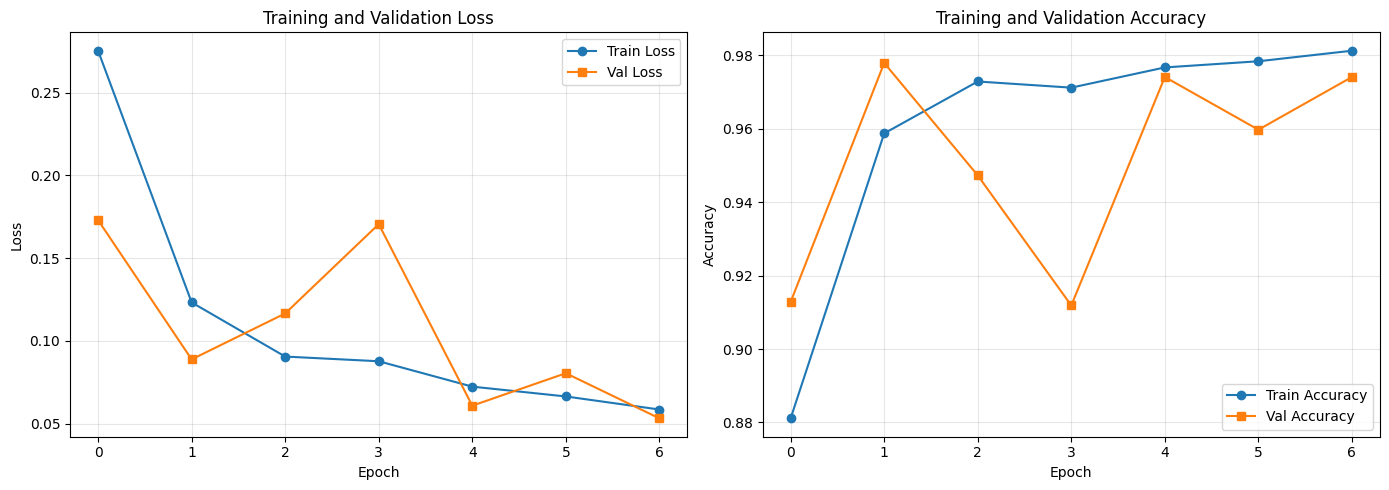


[4/5] Evaluating model...

TEST SET EVALUATION
Overall Accuracy: 0.8974

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.99      0.74      0.84       234
   PNEUMONIA       0.86      0.99      0.92       390

    accuracy                           0.90       624
   macro avg       0.93      0.86      0.88       624
weighted avg       0.91      0.90      0.89       624



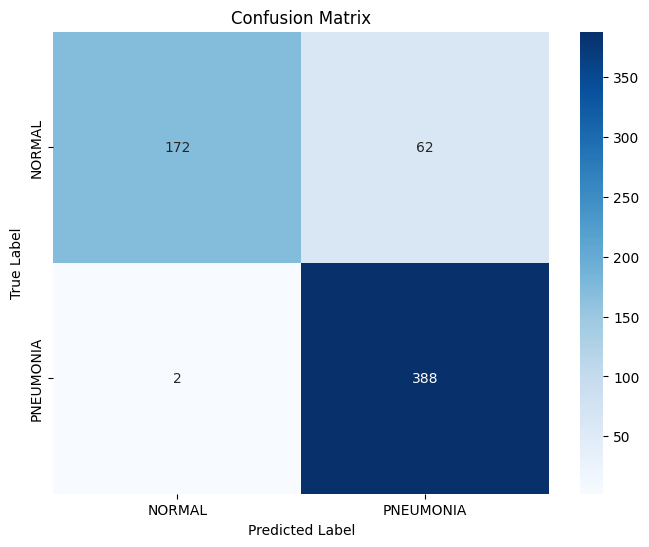


[5/5] Initializing XAI explainers...

✓ Pipeline complete!
✓ Model saved to: densenet121_pneumonia_detector.pth
✓ Results saved to: results/


In [12]:
def run_pipeline():
    """Main execution pipeline"""

    os.makedirs(Config.RESULTS_DIR, exist_ok=True)

    print("="*70)
    print("EXPLAINABLE AI FOR PNEUMONIA DETECTION - IMPROVED VERSION")
    print("="*70)
    print(f"\nDevice: {Config.DEVICE}")

    # Step 1: Load data with proper split
    print("\n[1/5] Loading data with stratified split...")
    train_loader, val_loader, test_loader, class_weights = create_dataloaders()

    # Step 2: Initialize model
    print("\n[2/5] Initializing improved model...")
    model = PneumoniaDetector(
        num_classes=Config.NUM_CLASSES,
        pretrained=Config.PRETRAINED
    ).to(Config.DEVICE)
    print(f"Model: DenseNet121 with {sum(p.numel() for p in model.parameters()):,} parameters")

    # Step 3: Train model
    print("\n[3/5] Training model with enhanced techniques...")
    history = train_model(model, train_loader, val_loader, Config.NUM_EPOCHS, class_weights)

    # Plot training history
    plot_training_history(history,
                         save_path=os.path.join(Config.RESULTS_DIR, 'training_history.png'))

    # Step 4: Evaluate model
    print("\n[4/5] Evaluating model...")
    model.load_state_dict(torch.load(Config.MODEL_SAVE_PATH))
    accuracy, preds, labels, probs = evaluate_model(model, test_loader)

    # Step 5: Initialize XAI explainers
    print("\n[5/5] Initializing XAI explainers...")
    gradcam_explainer = GradCAMExplainer(model)
    lime_explainer = LIMEExplainer(model)

    print("\n✓ Pipeline complete!")
    print(f"✓ Model saved to: {Config.MODEL_SAVE_PATH}")
    print(f"✓ Results saved to: {Config.RESULTS_DIR}/")

    return model, gradcam_explainer, lime_explainer, test_loader

# Run the complete pipeline
model, gradcam_explainer, lime_explainer, test_loader = run_pipeline()

In [13]:
def get_diverse_samples(test_loader, model, num_samples_per_category=2):
    """Get diverse samples: correct/incorrect predictions for both classes"""

    model.eval()
    samples = {
        'normal_correct': [],
        'normal_incorrect': [],
        'pneumonia_correct': [],
        'pneumonia_incorrect': []
    }

    class_names = ['NORMAL', 'PNEUMONIA']

    with torch.no_grad():
        for images, labels in test_loader:
            for i in range(len(images)):
                input_tensor = images[i:i+1].to(Config.DEVICE)
                output = model(input_tensor)
                probs = torch.nn.functional.softmax(output, dim=1)
                pred_class = output.argmax(dim=1).item()
                true_class = labels[i].item()
                confidence = probs[0][pred_class].item() * 100

                # Categorize sample
                if true_class == 0:  # NORMAL
                    if pred_class == true_class:
                        if len(samples['normal_correct']) < num_samples_per_category:
                            samples['normal_correct'].append((images[i], input_tensor, true_class, pred_class, confidence))
                    else:
                        if len(samples['normal_incorrect']) < num_samples_per_category:
                            samples['normal_incorrect'].append((images[i], input_tensor, true_class, pred_class, confidence))
                else:  # PNEUMONIA
                    if pred_class == true_class:
                        if len(samples['pneumonia_correct']) < num_samples_per_category:
                            samples['pneumonia_correct'].append((images[i], input_tensor, true_class, pred_class, confidence))
                    else:
                        if len(samples['pneumonia_incorrect']) < num_samples_per_category:
                            samples['pneumonia_incorrect'].append((images[i], input_tensor, true_class, pred_class, confidence))

                # Check if we have enough samples
                if all(len(v) >= num_samples_per_category for v in samples.values()):
                    return samples

    return samples


def visualize_diverse_explanations(model, gradcam_explainer, lime_explainer, test_loader):
    """Generate explanations for diverse samples"""

    print("\n" + "="*70)
    print("GENERATING DIVERSE EXPLANATIONS")
    print("="*70)

    samples = get_diverse_samples(test_loader, model, num_samples_per_category=1)

    categories = [
        ('normal_correct', '✓ NORMAL - Correctly Predicted'),
        ('normal_incorrect', '✗ NORMAL - Incorrectly Predicted'),
        ('pneumonia_correct', '✓ PNEUMONIA - Correctly Predicted'),
        ('pneumonia_incorrect', '✗ PNEUMONIA - Incorrectly Predicted')
    ]

    sample_idx = 1

    for category_key, category_name in categories:
        if samples[category_key]:
            print(f"\n{'='*60}")
            print(f"Sample {sample_idx}: {category_name}")
            print(f"{'='*60}")

            img_tensor, input_tensor, true_class, pred_class, confidence = samples[category_key][0]
            original_img = denormalize_image(img_tensor)

            class_names = ['NORMAL', 'PNEUMONIA']
            print(f"True Label: {class_names[true_class]}")
            print(f"Predicted: {class_names[pred_class]} (confidence: {confidence:.2f}%)")

            # Generate Grad-CAM
            print("Generating Grad-CAM explanation...")
            heatmap = gradcam_explainer.generate_explanation(input_tensor)
            heatmap_resized = np.array(Image.fromarray(heatmap).resize((224, 224)))
            gradcam_explainer.visualize(
                original_img,
                heatmap_resized,
                pred_class,
                true_class,
                confidence,
                save_path=os.path.join(Config.RESULTS_DIR, f'gradcam_{category_key}.png')
            )

            # Generate LIME
        print("Generating LIME explanation...")
        lime_img = (original_img * 255).astype(np.uint8)
        lime_explanation = lime_explainer.generate_explanation(lime_img, num_samples=500)
        lime_explainer.visualize(
            lime_img,
            lime_explanation,
            pred_class,
            pred_class,
            true_class,
            confidence,
            save_path=os.path.join(Config.RESULTS_DIR, f'lime_{category_key}.png')
        )

        sample_idx += 1
    else:
        print(f"\n⚠️ No samples found for: {category_name}")

print("\n✓ All diverse explanations generated!")
print(f"✓ Check the '{Config.RESULTS_DIR}/' directory for saved visualizations")


✓ All diverse explanations generated!
✓ Check the 'results/' directory for saved visualizations



GENERATING DIVERSE EXPLANATIONS

Sample 1: ✓ NORMAL - Correctly Predicted
True Label: NORMAL
Predicted: NORMAL (confidence: 56.14%)
Generating Grad-CAM explanation...


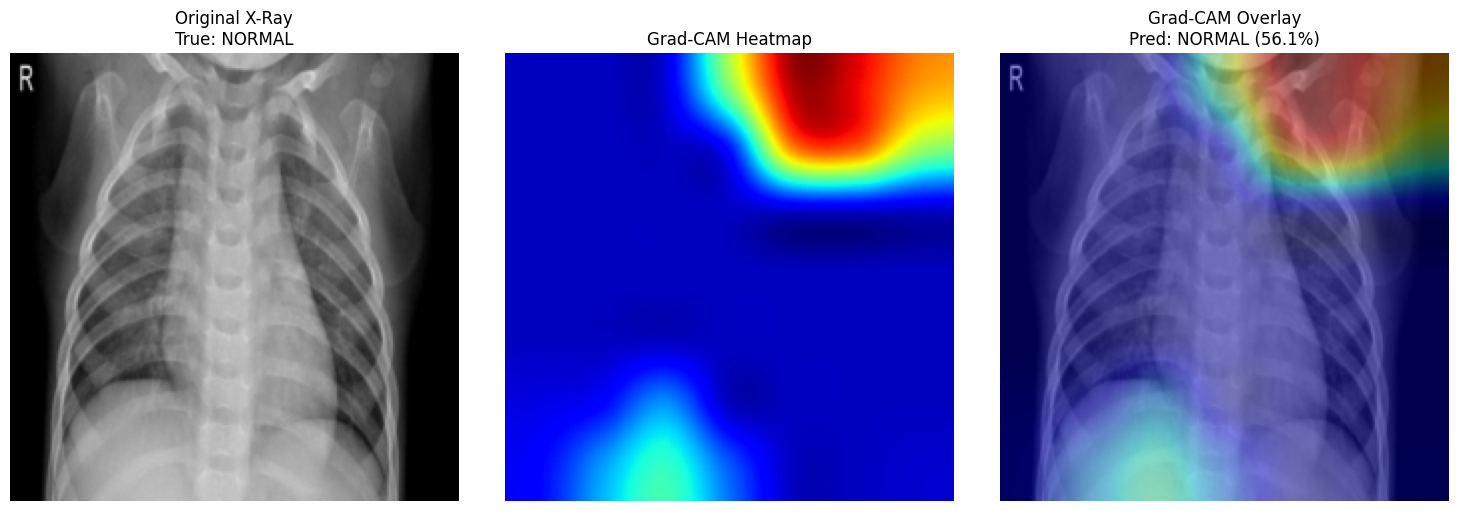

Generating LIME explanation...


  0%|          | 0/500 [00:00<?, ?it/s]

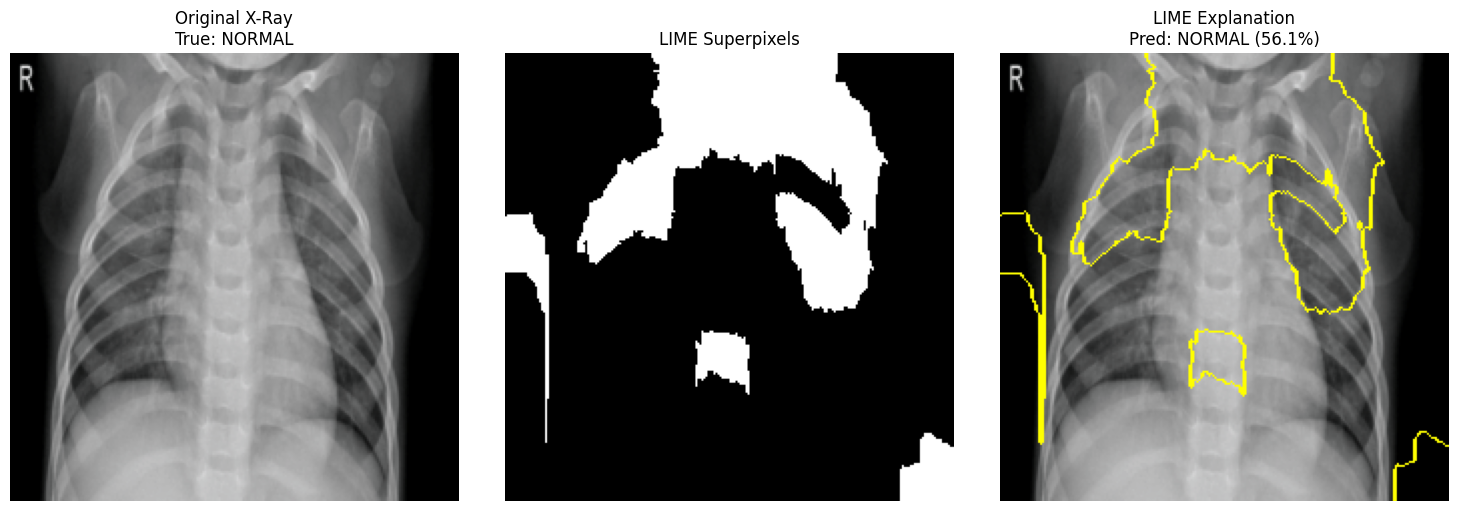


Sample 2: ✗ NORMAL - Incorrectly Predicted
True Label: NORMAL
Predicted: PNEUMONIA (confidence: 96.46%)
Generating Grad-CAM explanation...


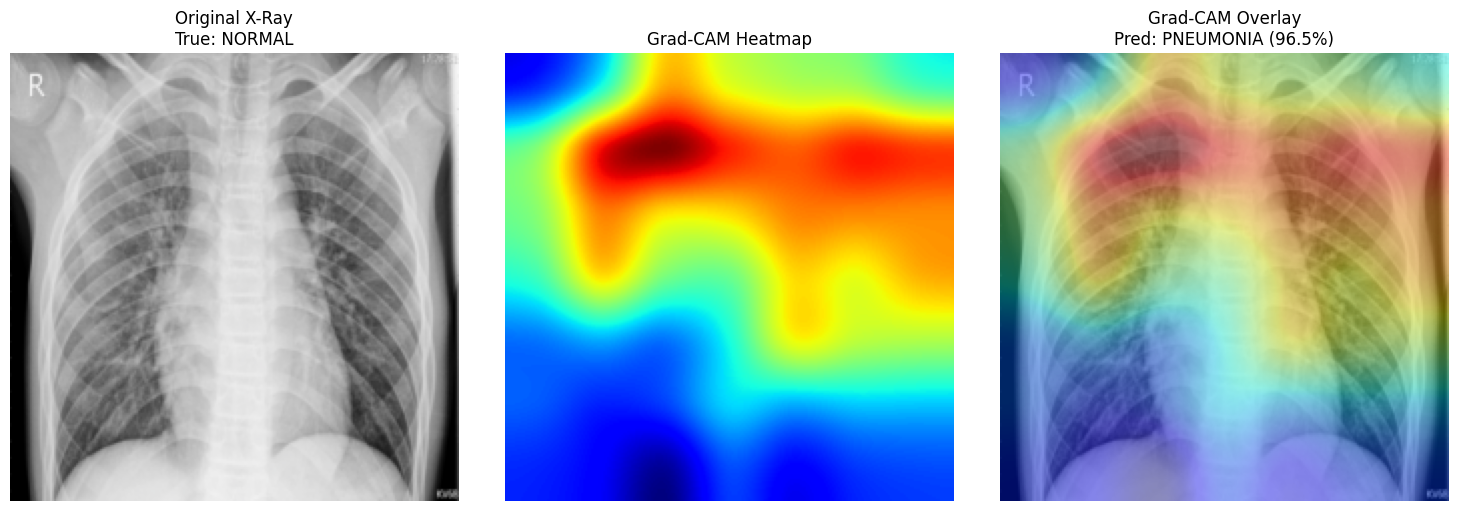

Generating LIME explanation...


  0%|          | 0/500 [00:00<?, ?it/s]

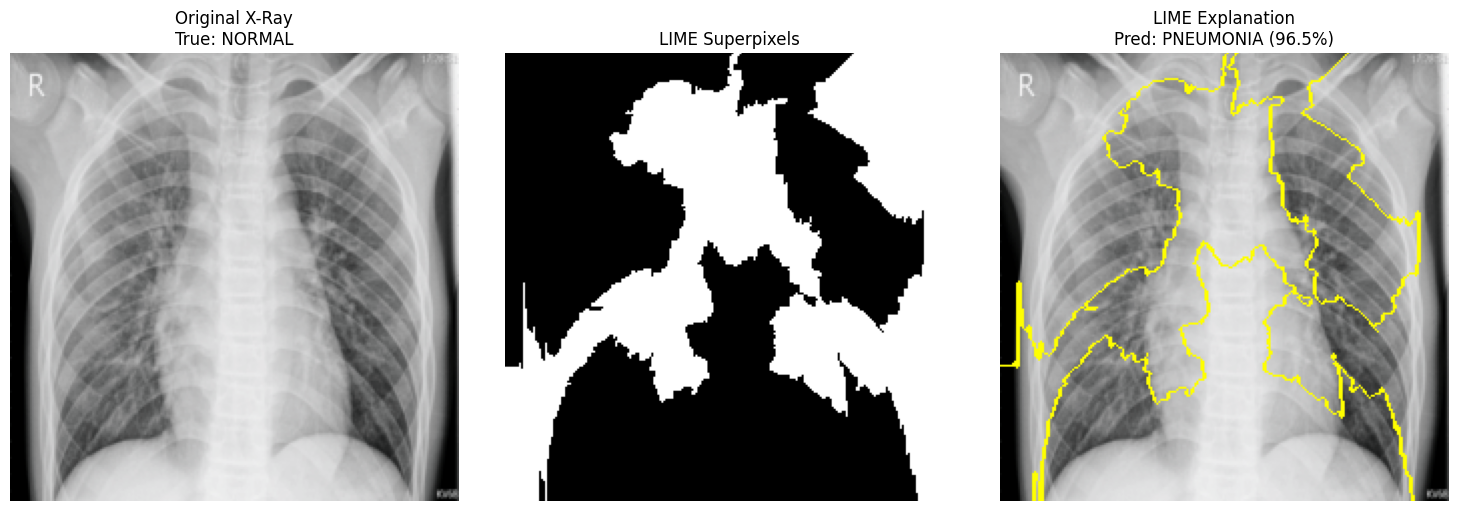


Sample 3: ✓ PNEUMONIA - Correctly Predicted
True Label: PNEUMONIA
Predicted: PNEUMONIA (confidence: 92.36%)
Generating Grad-CAM explanation...


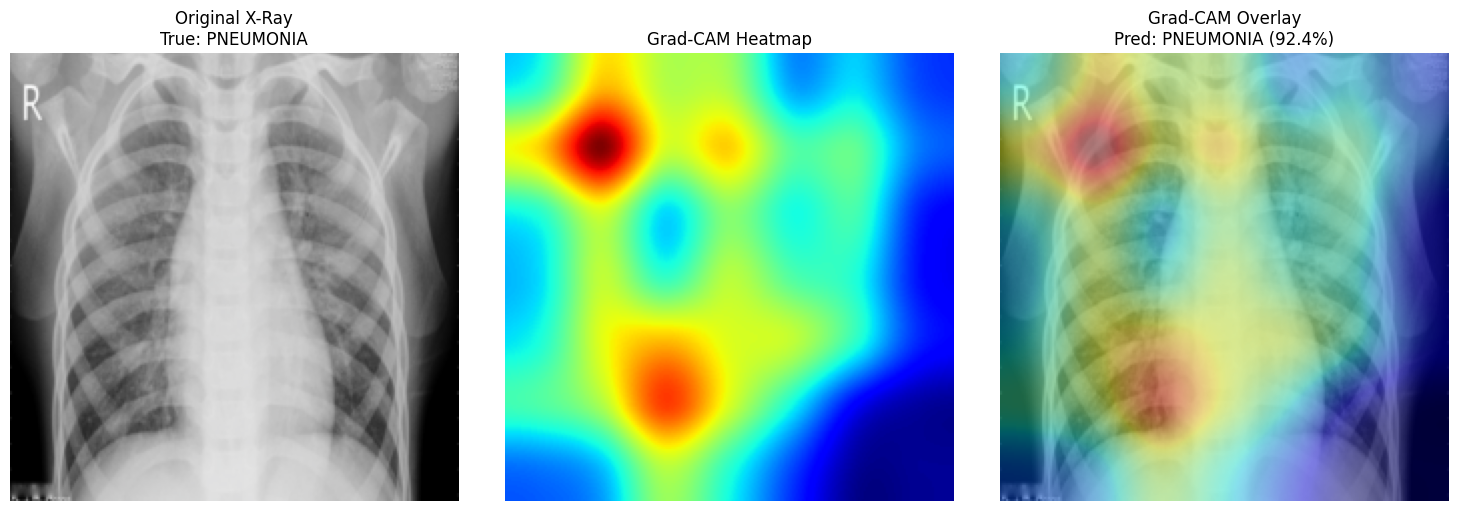

Generating LIME explanation...


  0%|          | 0/500 [00:00<?, ?it/s]

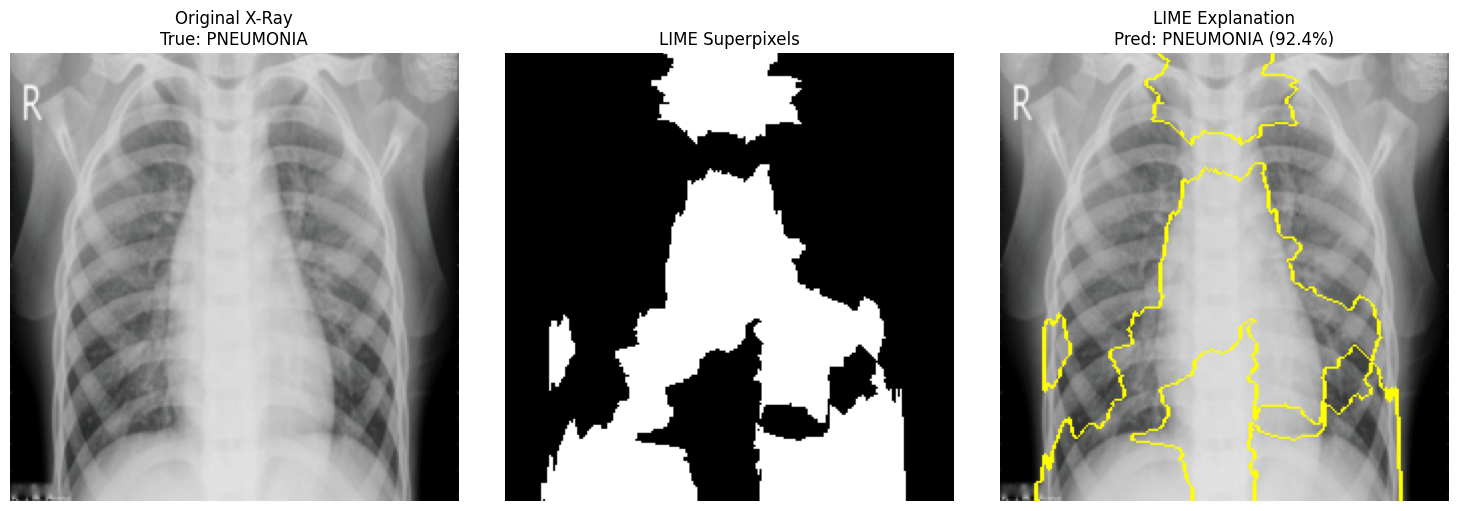


Sample 4: ✗ PNEUMONIA - Incorrectly Predicted
True Label: PNEUMONIA
Predicted: NORMAL (confidence: 68.07%)
Generating Grad-CAM explanation...


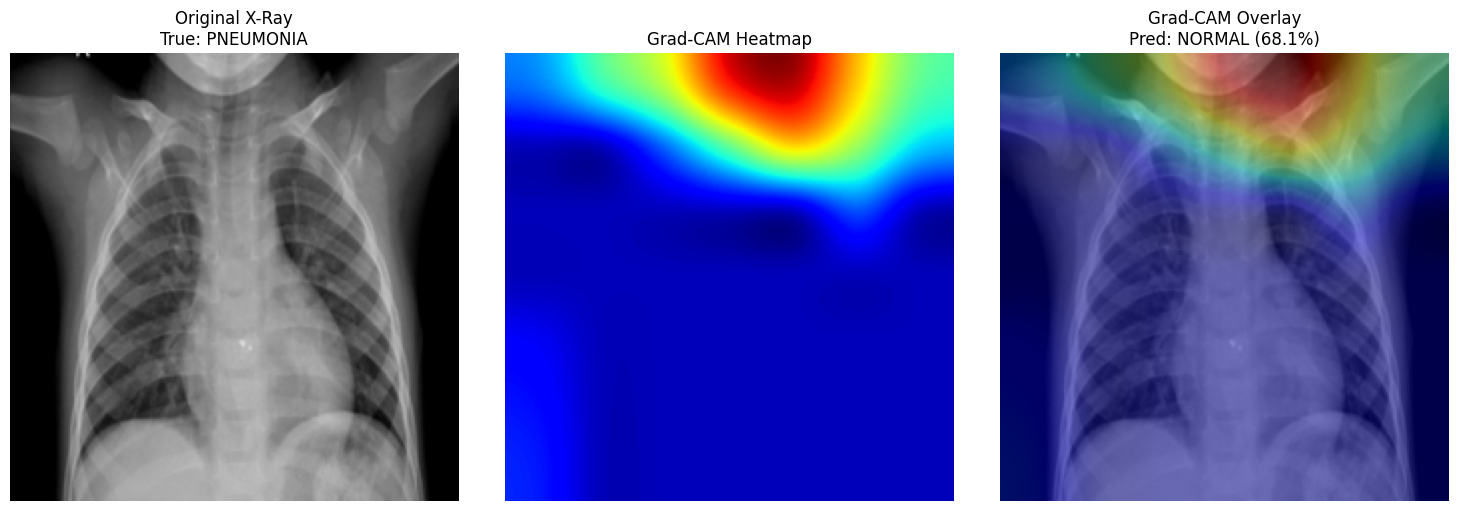

Generating LIME explanation...


  0%|          | 0/500 [00:00<?, ?it/s]

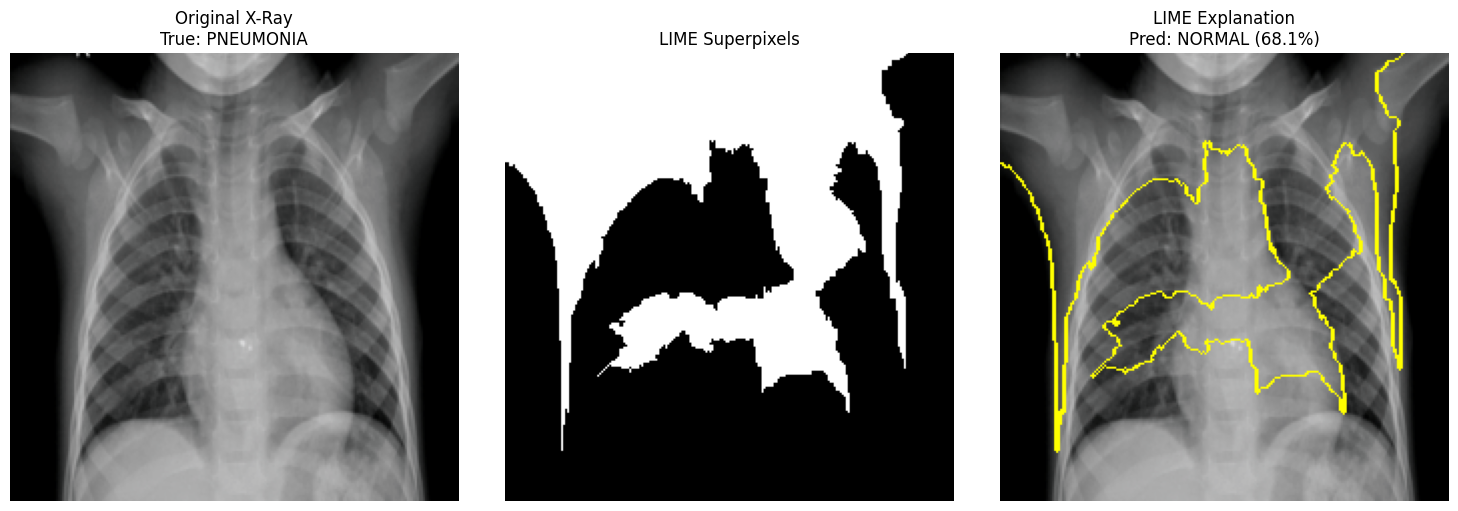


✓ All diverse explanations generated!
✓ Check the 'results/' directory for saved visualizations

✓ COMPLETE PIPELINE FINISHED!

Key Improvements:
  • Proper validation split (20% stratified)
  • Enhanced data augmentation
  • Class weights for imbalanced dataset
  • Learning rate scheduling
  • Early stopping
  • Diverse sample visualization (both classes, correct & incorrect)

All results saved in: results/


In [14]:
def get_diverse_samples(test_loader, model, num_samples_per_category=2):
    """Get diverse samples: correct/incorrect predictions for both classes"""

    model.eval()
    samples = {
        'normal_correct': [],
        'normal_incorrect': [],
        'pneumonia_correct': [],
        'pneumonia_incorrect': []
    }

    class_names = ['NORMAL', 'PNEUMONIA']

    with torch.no_grad():
        for images, labels in test_loader:
            for i in range(len(images)):
                input_tensor = images[i:i+1].to(Config.DEVICE)
                output = model(input_tensor)
                probs = torch.nn.functional.softmax(output, dim=1)
                pred_class = output.argmax(dim=1).item()
                true_class = labels[i].item()
                confidence = probs[0][pred_class].item() * 100

                # Categorize sample
                if true_class == 0:  # NORMAL
                    if pred_class == true_class:
                        if len(samples['normal_correct']) < num_samples_per_category:
                            samples['normal_correct'].append((images[i], input_tensor, true_class, pred_class, confidence))
                    else:
                        if len(samples['normal_incorrect']) < num_samples_per_category:
                            samples['normal_incorrect'].append((images[i], input_tensor, true_class, pred_class, confidence))
                else:  # PNEUMONIA
                    if pred_class == true_class:
                        if len(samples['pneumonia_correct']) < num_samples_per_category:
                            samples['pneumonia_correct'].append((images[i], input_tensor, true_class, pred_class, confidence))
                    else:
                        if len(samples['pneumonia_incorrect']) < num_samples_per_category:
                            samples['pneumonia_incorrect'].append((images[i], input_tensor, true_class, pred_class, confidence))

                # Check if we have enough samples
                if all(len(v) >= num_samples_per_category for v in samples.values()):
                    return samples

    return samples


def visualize_diverse_explanations(model, gradcam_explainer, lime_explainer, test_loader):
    """Generate explanations for diverse samples"""

    print("\n" + "="*70)
    print("GENERATING DIVERSE EXPLANATIONS")
    print("="*70)

    samples = get_diverse_samples(test_loader, model, num_samples_per_category=1)

    categories = [
        ('normal_correct', '✓ NORMAL - Correctly Predicted'),
        ('normal_incorrect', '✗ NORMAL - Incorrectly Predicted'),
        ('pneumonia_correct', '✓ PNEUMONIA - Correctly Predicted'),
        ('pneumonia_incorrect', '✗ PNEUMONIA - Incorrectly Predicted')
    ]

    sample_idx = 1

    for category_key, category_name in categories:
        if samples[category_key]:
            print(f"\n{'='*60}")
            print(f"Sample {sample_idx}: {category_name}")
            print(f"{'='*60}")

            img_tensor, input_tensor, true_class, pred_class, confidence = samples[category_key][0]
            original_img = denormalize_image(img_tensor)

            class_names = ['NORMAL', 'PNEUMONIA']
            print(f"True Label: {class_names[true_class]}")
            print(f"Predicted: {class_names[pred_class]} (confidence: {confidence:.2f}%)")

            # Generate Grad-CAM
            print("Generating Grad-CAM explanation...")
            heatmap = gradcam_explainer.generate_explanation(input_tensor)
            heatmap_resized = np.array(Image.fromarray(heatmap).resize((224, 224)))
            gradcam_explainer.visualize(
                original_img,
                heatmap_resized,
                pred_class,
                true_class,
                confidence,
                save_path=os.path.join(Config.RESULTS_DIR, f'gradcam_{category_key}.png')
            )

            # Generate LIME
            print("Generating LIME explanation...")
            lime_img = (original_img * 255).astype(np.uint8)
            lime_explanation = lime_explainer.generate_explanation(lime_img, num_samples=500)
            lime_explainer.visualize(
                lime_img,
                lime_explanation,
                pred_class,
                pred_class,
                true_class,
                confidence,
                save_path=os.path.join(Config.RESULTS_DIR, f'lime_{category_key}.png')
            )

            sample_idx += 1
        else:
            print(f"\n⚠️ No samples found for: {category_name}")

    print("\n✓ All diverse explanations generated!")
    print(f"✓ Check the '{Config.RESULTS_DIR}/' directory for saved visualizations")


# Generate diverse explanations
visualize_diverse_explanations(model, gradcam_explainer, lime_explainer, test_loader)

print("\n" + "="*70)
print("✓ COMPLETE PIPELINE FINISHED!")
print("="*70)
print(f"\nKey Improvements:")
print(f"  • Proper validation split (20% stratified)")
print(f"  • Enhanced data augmentation")
print(f"  • Class weights for imbalanced dataset")
print(f"  • Learning rate scheduling")
print(f"  • Early stopping")
print(f"  • Diverse sample visualization (both classes, correct & incorrect)")
print(f"\nAll results saved in: {Config.RESULTS_DIR}/")